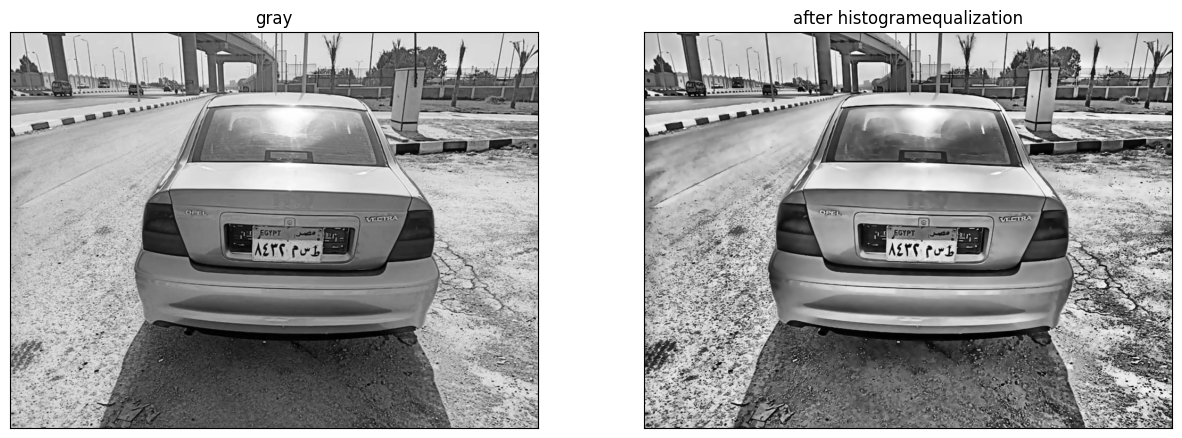

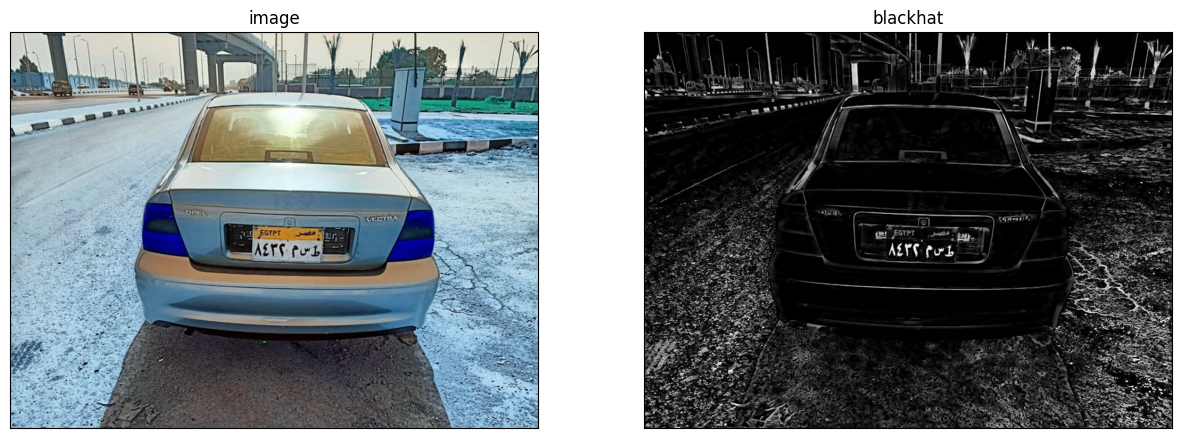

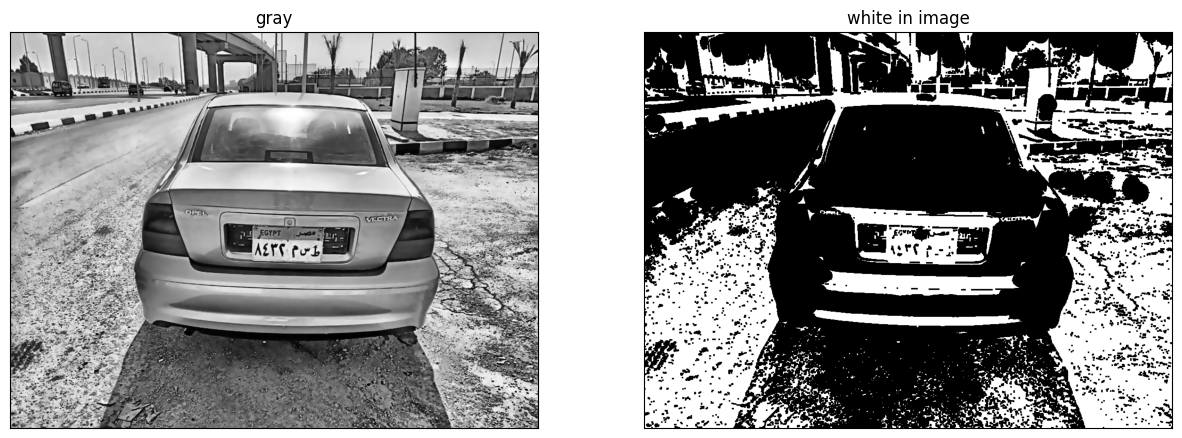

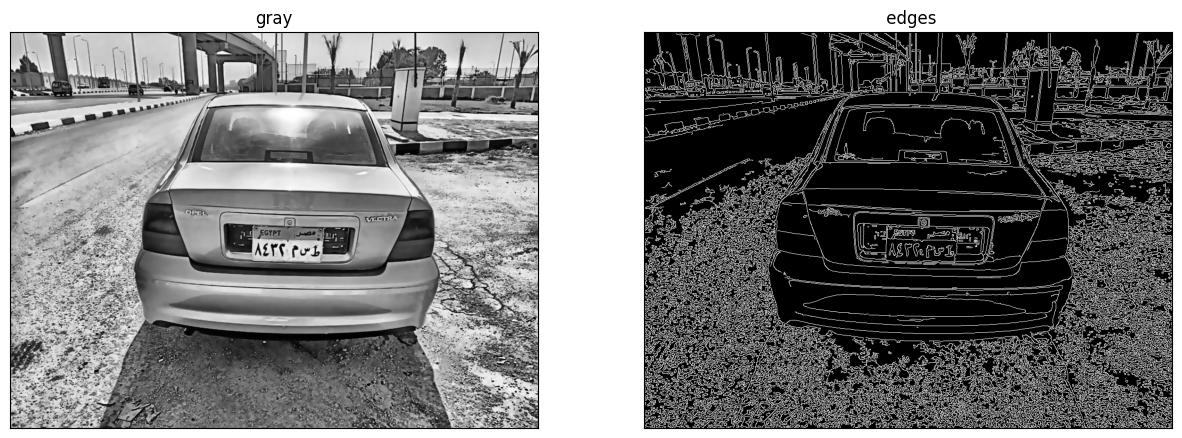

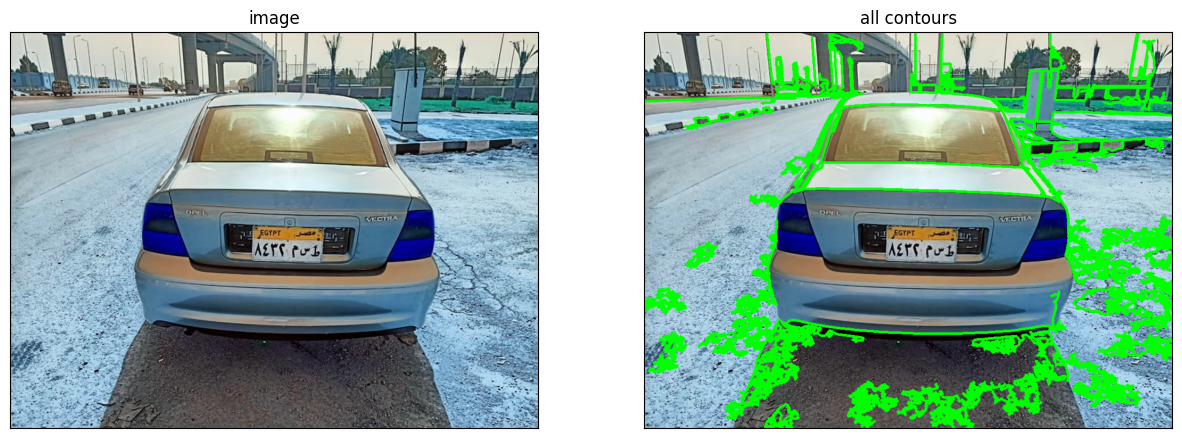

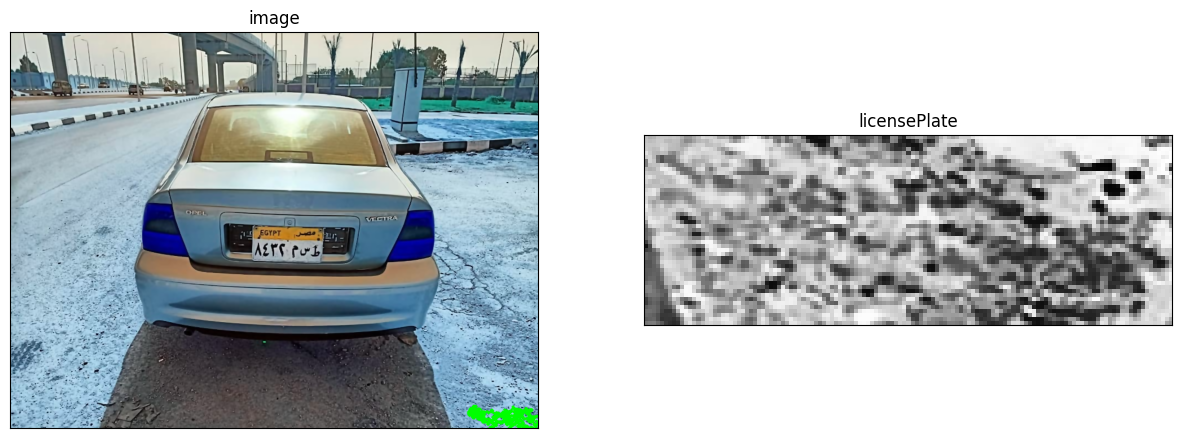

In [13]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
from skimage.segmentation import clear_border


minAR = 1.5
maxAR = 4
minArea = 600
maxArea = 10_000


def plot_images(img1, img2, title1="", title2=""):
    fig = plt.figure(figsize=[15, 15])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)

    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)
    plt.show()


def draw_contours(thresholded, image):
    # Find contours
    contours, _ = cv2.findContours(
        thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]
    # Draw all contours on the original image
    cv2.drawContours(image, contours, -1, (0, 255, 0), 3)
    return image


filename = "../../data/Testing dataset/7.jpg"

image = cv2.imread(filename)

# resize image to 1024 width
scale_factor = 1024 / image.shape[1]
image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)

gray_1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(15, 10))
gray = clahe.apply(gray_1)

gray = cv2.bilateralFilter(gray, d=11, sigmaColor=17, sigmaSpace=17)

plot_images(gray_1, gray, "gray", "after histogramequalization")

radius = 15
disk_kernel = cv2.getStructuringElement(
    cv2.MORPH_ELLIPSE, (2 * radius + 1, 2 * radius + 1), (radius, radius)
)
opened_image = cv2.morphologyEx(gray, cv2.MORPH_OPEN, disk_kernel)

subtracted_image = cv2.subtract(gray, opened_image)


""" perform a blackhat morphological operation to reveal dark characters (letters, digits, and symbols)
 against light backgrounds (the license plate itself)"""
rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 7))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
plot_images(image, blackhat, "image", "blackhat")


""" find regions in the image that are light and may contain license plate characters
find regions in the image that are light and may contain license plate characters """
squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
light = cv2.morphologyEx(subtracted_image, cv2.MORPH_CLOSE, squareKern)
light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plot_images(gray, light, "gray", "white in image")

gradX = cv2.Canny(gray, 20, 225)
canny = gradX.copy()

plot_images(gray, gradX, "gray", " edges")
"""smooth to group the regions that may contain boundaries to license plate characters"""

# gradX = cv2.GaussianBlur(gradX, (7, 7), 0)
# plot_images(gray, gradX, "gray", "smoothed")
#
# gradX = cv2.morphologyEx(
#     gradX, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
# )
# plot_images(gray, gradX, "gray", "closed")

# thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# plot_images(gray, thresh, "gray", "thresholded")

# """ there are many other large white regions as well
#     perform a series of erosions and dilations in an attempt to denoise
# """
# thresh = cv2.erode(thresh, None, iterations=2)
# plot_images(gray, thresh, "gray", "erode")

# thresh = cv2.dilate(thresh, None, iterations=2)
# plot_images(gray, thresh, "gray", "thresholded after erode dilate")

"""
light image serves as our mask for a bitwise-AND between the thresholded result and
the light regions of the image to reveal the license plate candidates.
follow with a couple of dilations and an erosion
to fill holes and clean up the image
 """

# thresh = cv2.bitwise_and(thresh, thresh, mask=light)
# thresh = cv2.dilate(thresh, None, iterations=2)
# thresh = cv2.erode(thresh, None, iterations=1)


# thresh = cv2.GaussianBlur(thresh, (5, 5), 0)
# thresh = cv2.dilate(
#     thresh, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1)), iterations=1
# )

# plot_images(gray, thresh, "gray", "After anding with light and closing")

"""
 show me all contours
"""
all_Contours = draw_contours(gradX.copy(), image.copy())
plot_images(image, all_Contours, "image", "all contours")

"""
find more relative contour

"""
cnts = cv2.findContours(gradX.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]

lpCnt = None
roi = None
main_contours = []  # list of contours that match the aspect ratio

for i, c in enumerate(cnts):
    area = cv2.contourArea(c)
    (x, y, w, h) = cv2.boundingRect(c)
    area_ratio = area / (w * h)
    ar = w / float(h)

    if minAR <= ar <= maxAR and minArea <= w * h <= maxArea:
        lpCnt = c
        licensePlate = gray[y : y + h, x : x + w]
        # roi = cv2.threshold(licensePlate, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        main_contours.append(c)

most_rectangular_contour = None
min_diff = float("inf")
last_contour = []
x_final = 0
y_final = 0
w_final = 0
h_final = 0

# Iterate over the contours
for i, c in enumerate(main_contours):
    # Calculate the bounding rectangle
    x, y, w, h = cv2.boundingRect(c)
    # Calculate the aspect ratio of the bounding rectangle
    ar = w / float(h)
    # Calculate the difference between the aspect ratio of the bounding rectangle and the aspect ratio of a perfect rectangle
    diff = abs(ar - 4)
    # If this difference is smaller than the smallest difference we've seen so far, update the most rectangular contour and the smallest difference
    if diff < min_diff:
        most_rectangular_contour = c
        min_diff = diff
        x_final = x
        y_final = y
        w_final = w
        h_final = h
last_contour.append(most_rectangular_contour)
licensePlate = gray[y_final : y_final + h_final, x_final : x_final + w_final]

# Now most_rectangular_contour is the contour with the most rectangular shape
######################################################################
image = cv2.imread(filename)
image = cv2.bilateralFilter(image, d=5, sigmaColor=80, sigmaSpace=80)
cv2.drawContours(image, last_contour, -1, (0, 255, 0), 3)
# plot_images(image, contour_image, "image with most rectangular contour", "all contours")
# plot_images(image,image,"image","licensePlate")

if (licensePlate != None).any():
    plot_images(image, licensePlate, "image", "licensePlate")


# roi=clear_border(roi)
# plot_images(image,roi)